# Tutorial 11: Debugging

## Overview
In this tutorial we are going to cover:

* [Pipeline Debugging](#t11PipelineDebugging)
    * [Debugging a Single NumpyOp](#t11SingleNumpyop)
    * [Debugging and Verifying the Pipeline Results](#t11VerifyPipeline)
* [Network Debugging](#t11NetworkDebugging)
    * [Debugging a Single TensorOp](#t11SingleTensorOp)
    * [Debugging and Verifying the Network Results](#t11VerifyNetwork)
* [Trace Debugging](#t11TraceDebugging)
    * [Conditional Debugging During Training](#t11Conditional)
    * [Debugging Pipeline and Network from a Trace](#t11DebugPiplineNetwork)

## Pipeline Debugging

In [Tutorial 4](./t04_pipeline.ipynb) we demonstrated what the Pipeline is and how it is created to handle different preprocessing tasks using `NumpyOp`s. Since the pipeline consists of a series of NumpyOps, it's a vital to know how to debug those `NumpyOp`s. 
It is also a good practice to inspect the results of the pipeline and ensure that the output is as you expected.<br>

There are two ways we can debug the `Pipeline`,
1. Debug a single `NumpyOp`
2. Debug and verify the results of `Pipeline`

### Debugging a Single NumpyOp

We will first create a simple `Pipeline` with a few `NumpyOps` that add random noise and rotate the image.

Now, if we want to debug the variable values in the `AddNoise` op we will do the following,
1. Set the <b>num_process=0</b> to disable the multiprocessing
2. Add your choice of a debugger such as the python debugger (PDB), an IDE specific debugger, or print statement in the `NumpyOp`

In [1]:
import numpy as np
import fastestimator as fe

from fastestimator.dataset.data import mnist
from fastestimator.op.numpyop import NumpyOp
from fastestimator.op.numpyop.multivariate import Rotate

from fastestimator.architecture.tensorflow import LeNet

In [2]:
train_data, eval_data = mnist.load_data()
test_data = eval_data.split(0.5)
model = fe.build(model_fn=LeNet, optimizer_fn="adam")

Single `NumpyOp` can be debugged in two ways,
* Using `Pipeline.transform`
* Running the training loop

#### Using Pipeline.transform

In [3]:
class AddNoiseDebug(NumpyOp):
    def __init__(self, inputs, outputs, mode = None):
        super().__init__(inputs, outputs, mode)

    def forward(self, data, state):
        noise = np.random.normal(0, 1, size=data.shape)
        print('Noise shape ', noise.shape)
        print('data shape ', data.shape) # add print statement to check the data and noise
        data = data + noise
        return data

In [4]:
debug_pipeline = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       test_data=test_data,
                       batch_size=3,
                       ops=[AddNoiseDebug(inputs='x', outputs='x_out'),
                            Rotate(image_in="x_out", image_out="x_out", limit=60)], 
                             num_process=0)

In [5]:
results = debug_pipeline.transform(train_data[0], mode='train')

Noise shape  (28, 28)
data shape  (28, 28)


#### Running the Training Loop

In [6]:
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

In [7]:
network = fe.Network(ops=[ModelOp(model=model, inputs="x_out", outputs="y_pred"),
                          CrossEntropy(inputs=("y_pred", "y"), outputs="ce", mode="!infer"),
                          UpdateOp(model=model, loss_name="ce", mode="train")])

NOTE: The training logs will print extra debug messages if warmup is not set to False in `Estimator.fit`. When warmup is enabled it will perform a test run on both `Pipeline` and `Network` to make sure that training will not fail in later stages. 

In [8]:
estimator = fe.Estimator(pipeline=debug_pipeline,
                         network=network,
                         epochs=1,
                         train_steps_per_epoch=1, 
                         eval_steps_per_epoch=1)
estimator.fit(warmup=False)

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-Start: step: 1; logging_interval: 100; num_device: 0;
Noise shape  (28, 28)
data shape  (28, 28)
FastEstimator-Warn: the key 'x' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.
FastEstimator-Train: step: 1; ce: 41.828907;
FastEstimator-Train: step: 1; epoch: 1; epoch_time: 2.29 sec;
Noise shape  (28, 28)
data shape  (28, 28)
FastEstimator-Eval: step: 1; epoch: 1; ce: 12.470611;
F

### Debugging and Verifying the Pipeline Results

In order to debug and verify the pipeline results, we will use the `pipeline.get_results()`. You can also visualize the results using the utility function `paint_figure`.

Noise shape  (28, 28)
data shape  (28, 28)
Noise shape  (28, 28)
data shape  (28, 28)
Noise shape  (28, 28)
data shape  (28, 28)


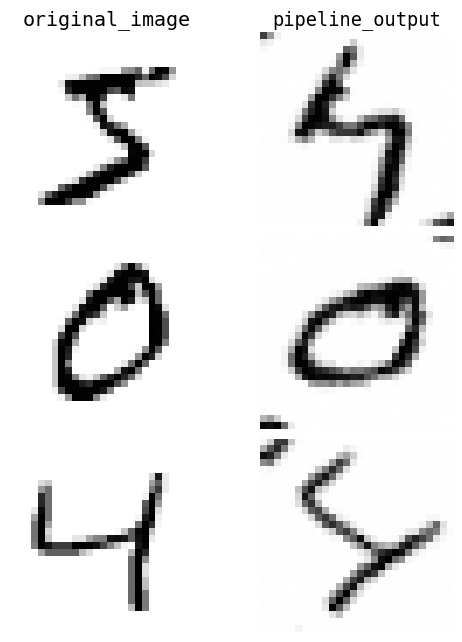

In [9]:
data = debug_pipeline.get_results()
img = fe.util.ImgData(original_image=data["x"], pipeline_output=data["x_out"])
fig = img.paint_figure()

## Network Debugging

`Network` defines the model and the operations that need to be performed on it. It is composed of series of TensorOps and can be debugged in similar fashion as the `Pipeline`.
1. Debugging the single `TensorOp`
2. Verify and debug the network results

### Debugging a Single TensorOp

A TensorOp can be debugged in two ways,
* Using `network.transform`
* Running the training loop

#### Using Network.transform

We will add a Custom `TensorOp` that will print the value of prediction and run the forward step through the network using `network.transform`.

In [10]:
import tensorflow as tf
from fastestimator.op.tensorop import TensorOp

In [11]:
class CustomTensorOp(TensorOp):
    def forward(self, data, state):
        pred = data[0]
        labels = data[1]
        print('Predictions:\n ', pred)

In [12]:
pipeline = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       test_data=test_data,
                       batch_size=3,
                       ops=[Rotate(image_in="x", image_out="x_out", limit=60)])

In [13]:
network = fe.Network(ops=[ModelOp(model=model, inputs="x_out", outputs="y_pred"), #default mode=None
                          CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
                          CustomTensorOp(inputs=("y_pred", "y")),
                          UpdateOp(model=model, loss_name="ce", mode="train")])

In [14]:
test_data = pipeline.get_results(mode="test")
test_data = network.transform(test_data, mode="test")

Predictions:
  tf.Tensor(
[[1.04317516e-01 6.71256125e-01 1.14605345e-01 7.35315774e-03
  5.58792908e-11 1.56289605e-06 1.25122912e-10 4.26820382e-20
  1.86218854e-19 1.02466203e-01]
 [5.95768256e-07 9.99978065e-01 7.48018227e-12 5.28831424e-06
  1.21222710e-09 1.00591762e-06 1.92799471e-10 2.36348476e-11
  6.45342677e-12 1.51745189e-05]
 [9.60969010e-06 4.34214307e-04 2.30531512e-07 6.15865929e-06
  4.49502733e-14 9.99307513e-01 2.85619442e-14 6.24453699e-18
  4.17934892e-13 2.42165770e-04]], shape=(3, 10), dtype=float32)


As you can see, the predictions are getting displayed from the print statement in the `CustomTensorOp`

#### Running the Training Loop

In [15]:
class CustomTensorOp(TensorOp):
    def forward(self, data, state):
        pred = data[0]
        labels = data[1]
        tf.print(pred.shape) # tf.print will work in both graph mode and eager mode
        print(labels.shape) # print only work in eager mode for tensorflow

In [16]:
network = fe.Network(ops=[ModelOp(model=model, inputs="x_out", outputs="y_pred"), #default mode=None
                          CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
                          CustomTensorOp(inputs=("y_pred", "y")),
                          UpdateOp(model=model, loss_name="ce", mode="train")])

If you are using the <b>Tensorflow</b> backend it's important to set `eager=True` in the `Estimator.fit()` or can use the `tf.print` function to print in graph mode. For the <b>PyTorch</b> backend, you can use any of your favorite debuggers and no graph mode settings are required.

In [17]:
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=2,
                         train_steps_per_epoch=2, 
                         eval_steps_per_epoch=1,
                         log_steps=None)
estimator.fit(eager=True)

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
TensorShape([3, 10])
(3,)
TensorShape([3, 10])
(3,)
TensorShape([3, 10])
(3,)
TensorShape([3, 10])
(3,)
TensorShape([3, 10])
(3,)
TensorShape([3, 10])
(3,)
TensorShape([3, 10])
(3,)
TensorShape([3, 10])
(3,)


### Debugging and Verifying the Network Results

Now let's look at how to verify the output of the network using `network.transform`

In [18]:
network = fe.Network(ops=[ModelOp(model=model, inputs="x_out", outputs="y_pred"), #default mode=None
                          CrossEntropy(inputs=("y_pred", "y"), outputs="ce", mode="!infer"),
                          UpdateOp(model=model, loss_name="ce", mode="train")])

We will take the output of the pipeline and feed it into the network to verify that the network is giving us the output as was expected

In [19]:
test_data = pipeline.get_results(mode="test")
test_data = network.transform(test_data, mode="test")
print('Labels: ', test_data['y'])
print('Predictions: ', np.argmax(test_data['y_pred'].numpy(), axis=1))

Labels:  tf.Tensor([3 3 6], shape=(3,), dtype=uint8)
Predictions:  [9 0 9]


## Trace Debugging

### Conditional Debugging During Training

What if our training is giving some weird result for the specific sample after a certain number of training epochs? How do you debug such sample data based on specific conditions?

In [Tutorial 7](./t07_estimator.ipynb) we introduced the `Trace` and it's various use cases during the training. Since the trace allows us to control the training loop it is possible to add conditions that suit your needs to debug the training code.

Let's write a trace that prints the predictions and label values for second batch during the training. To access the training information inside the `Trace`, you can use the `System` instance as explained in [Advanced Tutorial 4](../advanced/t04_trace.ipynb).

In [20]:
from fastestimator.trace import Trace
from fastestimator.trace.metric import Accuracy

In [21]:
class MonitorResult(Trace):
        
    def on_batch_end(self, data):
        if self.system.batch_idx == 2:
            predictions = np.argmax(data[self.inputs[1]].numpy(), axis=1)
            print('Current global step: ', self.system.global_step)
            print("Batch true labels: ", data[self.inputs[0]])
            print("Batch predictictions: ", predictions)

In [26]:
traces = [
    Accuracy(true_key="y", pred_key="y_pred"),
    MonitorResult(inputs=("y", "y_pred"), mode='train')
]
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=3,
                         traces=traces,
                         train_steps_per_epoch=15, 
                         log_steps=None)
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
Current global step:  2
Batch true labels:  tf.Tensor([1 9 4], shape=(3,), dtype=uint8)
Batch predictictions:  [8 7 0]
Current global step:  17
Batch true labels:  tf.Tensor([2 6 7], shape=(3,), dtype=uint8)
Batch predictictions:  [4 5 7]
Current global step:  32
Batch true labels:  tf.Tensor([1 9 3], shape=(3,), dtype=uint8)
Batch predictictions:  [3 9 8]


### Debugging Pipeline and Network From a Trace

Trace can also be used to debug the results of `Pipeline` and `Network`. In the previous example, we print the predictions and labels for epoch 2 and 3. But what if we want to debug the actual pipeline data used in the training.

We can use the same conditional debugging as before, only this time printing the results of the `Pipeline`. Let's write a trace that prints the pipeline output when the loss value crosses 2.

In [23]:
model = fe.build(model_fn=LeNet, optimizer_fn="adam")

In [24]:
class MonitorPipelineResults(Trace):
    def __init__(self, true_key, pred_key, mode="train"):
        super().__init__(inputs=(true_key, pred_key), mode=mode)
        
    def on_batch_end(self, data):
        if data['ce'] > 3 and self.system.epoch_idx >= 2:
            print('\nLoss is above 3. Check the pipeline results!')
            print(data['x_out'])

In [25]:
traces = [
    Accuracy(true_key="y", pred_key="y_pred"),
    MonitorPipelineResults(true_key="y", pred_key="y_pred")
]
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=3,
                         traces=traces,
                         train_steps_per_epoch=2)
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-Start: step: 1; logging_interval: 100; num_device: 0;
FastEstimator-Train: step: 1; ce: 1.912292;
FastEstimator-Train: step: 2; epoch: 1; epoch_time: 0.4 sec;
FastEstimator-Eval: step: 2; epoch: 1; accuracy: 0.3268; ce: 2.4979737;
FastEstimator-Train: step: 4; epoch: 2; epoch_time: 0.39 sec;
FastEstimator-Eval: step: 4; epoch: 2; accuracy: 0.324; ce: 2.55346;

Loss is above 3. Check the pipeline results!
tf.Tensor(
[[[  0   0   0 ...   0   0   0]
  [  0   0   0 ...  